
## Preprocesamiento de Datos

In [1]:
# Se importan librerías
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import spacy

In [2]:
# Modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')

# Lectura de los datos
data = pd.read_csv('comentarios.csv', sep=',')
comentarios = ' '.join(data['comentario'])

### Limpieza, tokenización y reducción del vocabulario

In [3]:
# Función para limpieza y tokenización
def limpiar_tokenizar(text):
    # Patrón de expresión regular para tokenización
    pattern = '\w+|:\)|:\(|[^.,;\s]'
    # Tokenización utilizando RegexpTokenizer
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(text)
    # Limpieza de tokens
    stop_words = set(stopwords.words('spanish'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    return tokens

In [4]:
# Función para lematizar tokens
def lematizar_texto(tokens):
    lemas = []
    for token in tokens:
        doc = nlp(token)
        lemas.append(doc[0].lemma_)
    return lemas

# Función para stemming tokens
def stem_texto(tokens):
    stemmer = SnowballStemmer('spanish')
    raices = [stemmer.stem(token) for token in tokens]
    return raices

In [5]:
# Se aplican las funciones a data
data['tokens'] = data['comentario'].apply(limpiar_tokenizar)
data['lemas'] = data['tokens'].apply(lematizar_texto)
data['raices'] = data['tokens'].apply(stem_texto)

In [6]:
# Se visualiza data incluyendo tokens, lemas y raices
data.head()

,orden,comentario,tipo,tokens,lemas,raices
0,1,"No les creo nada ,",malo,[creo],[creer],[cre]
1,2,Está bonita la camioneta,bueno,"[bonita, camioneta]","[bonito, camioneta]","[bonit, camionet]"
2,3,Quiero más información,info,"[quiero, información]","[querer, información]","[quier, inform]"
3,4,:( igual el crédito ha de ser muuuucho,malo,"[:(, igual, crédito, ser, muuuucho]","[:(, igual, crédito, ser, muuuucho]","[:(, igual, credit, ser, muuuuch]"
4,5,"Quisiera, más información, pero nadie me respo...",info,"[quisiera, información, nadie, responde]","[querer, información, nadie, responder]","[quis, inform, nadi, respond]"


### División de la muestra en entrenamiento y test

In [7]:
X = data.drop('tipo', axis=1)
y = data['tipo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [8]:
# Cantidad de registros para train y test
print("data_train tiene", data_train.shape[0], "registros y", data_train.shape[1], "columnas.")
print("data_test tiene", data_test.shape[0], "registros y", data_test.shape[1], "columnas.")

data_train tiene 480 registros y 6 columnas.
data_test tiene 120 registros y 6 columnas.


### Distribución del target según muestra, train y test

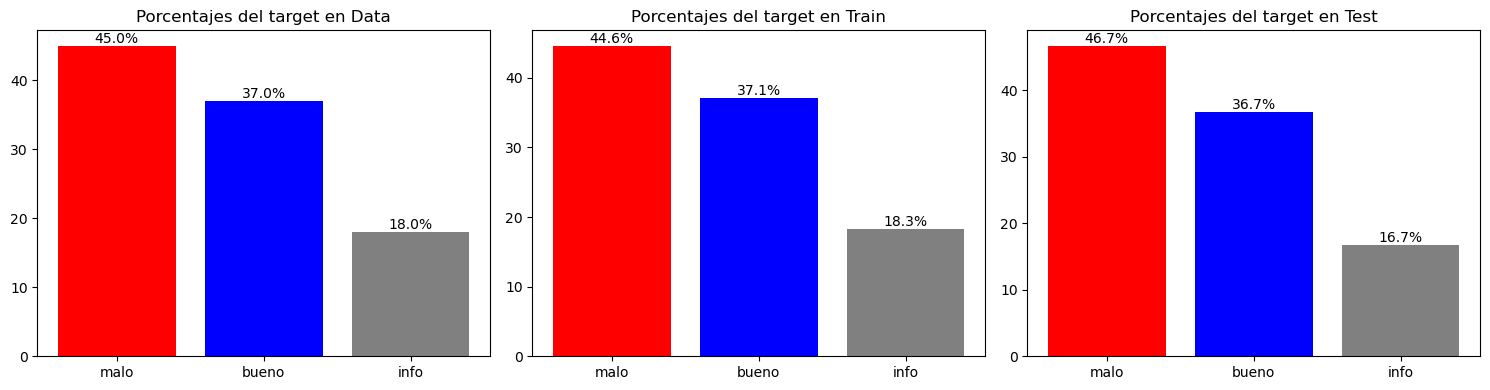

In [9]:
# Calcular porcentajes de muestra
data_total = len(data)
data_counts = data['tipo'].value_counts()
data_porcentaje = data_counts / data_total * 100

# Calcular porcentajes de train
train_total = len(data_train)
train_counts = data_train['tipo'].value_counts()
train_porcentaje = train_counts / train_total * 100

# Calcular porcentajes de test
test_total = len(data_test)
test_counts = data_test['tipo'].value_counts()
test_porcentaje = test_counts / test_total * 100

# Figura, subplots y colores para cada categoría
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
colors = {'malo': 'red', 'bueno': 'blue', 'info': 'gray'}

# Gráfico de barras para muestra
x_data = range(len(data_porcentaje))
ax1.bar(x_data, data_porcentaje, align='center', color=[colors.get(t, 'gray') for t in data_porcentaje.index])
ax1.set_title('Porcentajes del target en Data')
ax1.set_xticks(x_data)
ax1.set_xticklabels(data_porcentaje.index)
for i, percentage in enumerate(data_porcentaje):
    ax1.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

# Gráfico de barras para train
x_train = range(len(train_porcentaje))
ax2.bar(x_train, train_porcentaje, align='center', color=[colors.get(t, 'gray') for t in train_porcentaje.index])
ax2.set_title('Porcentajes del target en Train')
ax2.set_xticks(x_train)
ax2.set_xticklabels(train_porcentaje.index)
for i, percentage in enumerate(train_porcentaje):
    ax2.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

# Gráfico de barras para test
x_test = range(len(test_porcentaje))
ax3.bar(x_test, test_porcentaje, align='center', color=[colors.get(t, 'gray') for t in test_porcentaje.index])
ax3.set_title('Porcentajes del target en Test')
ax3.set_xticks(x_test)
ax3.set_xticklabels(test_porcentaje.index)
for i, percentage in enumerate(test_porcentaje):
    ax3.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Representación Vectorial

In [10]:
tfidf = TfidfVectorizer(token_pattern='\w+|:\)|:\(|[^.,;\s]')

# Se ajusta con los datos de entrenamiento X_train
tfidf_X_train = tfidf.fit_transform(X_train)

# Se transforma con los datos de X_test
tfidf_X_test = tfidf.transform(X_test)

In [11]:
feature_names = tfidf.get_feature_names_out()

# Se crea un DataFrame para mostrar la matriz tf-idf
tfidf_df = pd.DataFrame(np.round(tfidf_X_train.toarray(), 3), columns=feature_names)

print(tfidf_df)
print('\nLa forma de la matriz TF-IDF es:', tfidf_X_train.shape)

   comentario  lemas  orden  raices  tokens
0         0.0    0.0    1.0     0.0     0.0
1         1.0    0.0    0.0     0.0     0.0
2         0.0    0.0    0.0     0.0     1.0
3         0.0    1.0    0.0     0.0     0.0
4         0.0    0.0    0.0     1.0     0.0

La forma de la matriz TF-IDF es: (5, 5)
